In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, isnull

# Khởi tạo Spark Session
spark = SparkSession.builder.appName("Do uong Phan tich").getOrCreate()

# Tải dữ liệu từ file CSV
df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/Khai Phá Dữ Liệu Lớn/water_potability.csv", sep=';', header=True, inferSchema=True)

# Hiển thị cấu trúc dữ liệu
df.printSchema()

# Hiển thị một vài dòng dữ liệu đầu tiên
df.show(5)


root
 |-- ph: double (nullable = true)
 |-- Hardness: double (nullable = true)
 |-- Solids: double (nullable = true)
 |-- Chloramines: double (nullable = true)
 |-- Sulfate: double (nullable = true)
 |-- Conductivity: double (nullable = true)
 |-- Organic_carbon: double (nullable = true)
 |-- Trihalomethanes: double (nullable = true)
 |-- Turbidity: double (nullable = true)
 |-- Potability: integer (nullable = true)

+-----------+-----------+-----------+-----------+-----------+------------+--------------+---------------+-----------+----------+
|         ph|   Hardness|     Solids|Chloramines|    Sulfate|Conductivity|Organic_carbon|Trihalomethanes|  Turbidity|Potability|
+-----------+-----------+-----------+-----------+-----------+------------+--------------+---------------+-----------+----------+
|       NULL|204.8904555|20791.31898|7.300211873|368.5164413| 564.3086542|   10.37978308|    86.99097046|2.963135381|         0|
|3.716080075|129.4229205|18630.05786|6.635245884|       NULL| 5

# Tiền xử lý dữ liệu

In [ ]:
# Hiển thị cấu trúc dữ liệu
df.printSchema()

# Kiểm tra dữ liệu thiếu
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

# Hiển thị một vài dòng dữ liệu
df.show()


root
 |-- ph: double (nullable = true)
 |-- Hardness: double (nullable = true)
 |-- Solids: double (nullable = true)
 |-- Chloramines: double (nullable = true)
 |-- Sulfate: double (nullable = true)
 |-- Conductivity: double (nullable = true)
 |-- Organic_carbon: double (nullable = true)
 |-- Trihalomethanes: double (nullable = true)
 |-- Turbidity: double (nullable = true)
 |-- Potability: integer (nullable = true)

+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
| ph|Hardness|Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
|491|       0|     0|          0|    781|           0|             0|            162|        0|         0|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+

+-----------+-----------+-----------+------

In [ ]:
# Loại bỏ các hàng có giá trị thiếu
df_dropped = df.na.drop()

# Kiểm tra dữ liệu thiếu sau khi loại bỏ
df_dropped.select([count(when(isnull(c), c)).alias(c) for c in df_dropped.columns]).show()

+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
| ph|Hardness|Solids|Chloramines|Sulfate|Conductivity|Organic_carbon|Trihalomethanes|Turbidity|Potability|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+
|  0|       0|     0|          0|      0|           0|             0|              0|        0|         0|
+---+--------+------+-----------+-------+------------+--------------+---------------+---------+----------+



In [ ]:
# Hiển thị số dòng sau khi loại bỏ dữ liệu thiếu
print(f"Số dòng sau khi loại bỏ dữ liệu thiếu: {df_dropped.count()}")

Số dòng sau khi loại bỏ dữ liệu thiếu: 2011


# Heatmap hệ số tương quan giữa các đặc trưng chất lượng nước

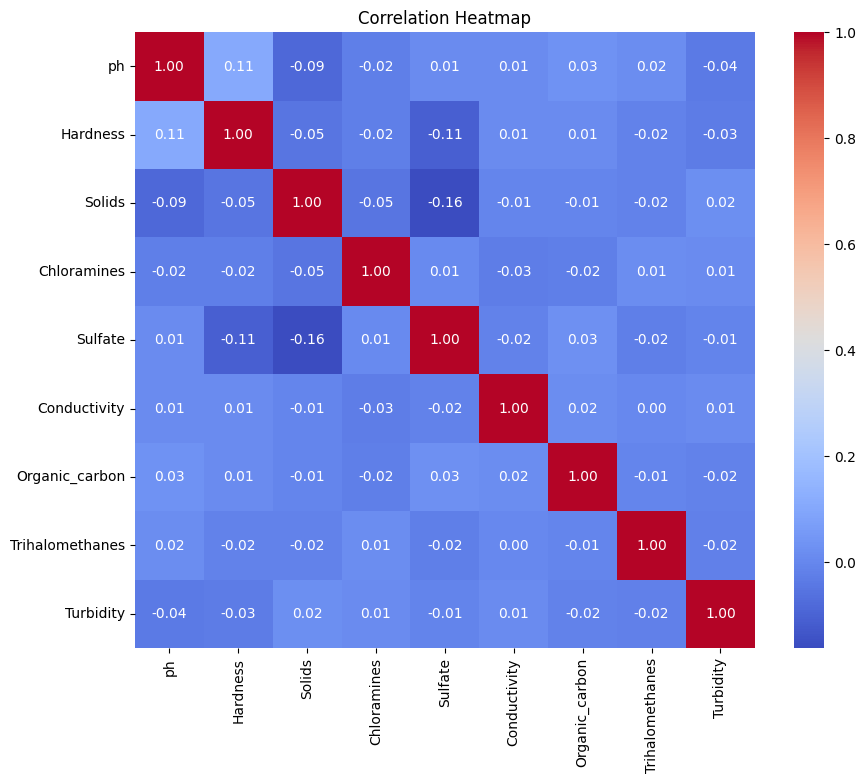

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bước 1: Chuyển đổi PySpark DataFrame thành Pandas DataFrame
pandas_df = df_dropped.toPandas()

# Bước 2: Lọc các cột số
numeric_df = pandas_df[['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity','Organic_carbon','Trihalomethanes','Turbidity']]

# Bước 3: Tạo heatmap cho các cột đã chọn
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

Kết quả heatmap cho thấy các đặc trưng trong bộ dữ liệu có hệ số tương quan rất thấp (gần 0). Nghĩa là chúng hầu như không phụ thuộc lẫn nhau. Trong trường hợp này, nếu gộp các biến lại sẽ làm mất đi thông tin riêng biệt của từng đặc trưng. Do đó, em quyết định giữ nguyên tất cả các cột thay vì gộp, vì cách này đảm bảo phân tích chính xác và giữ đầy đủ thông tin cho mô hình dự đoán độ an toàn nước.

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier

In [ ]:
# Chuyển đổi các cột thành vector đặc trưng
assembler = VectorAssembler(inputCols=[column for column in df_dropped.columns if column != 'Potability'], outputCol="features")
data = assembler.transform(df_dropped)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
train, test = data.randomSplit([0.7, 0.3], seed=42)


# TRỰC QUAN HOÁ DỮ LIỆU

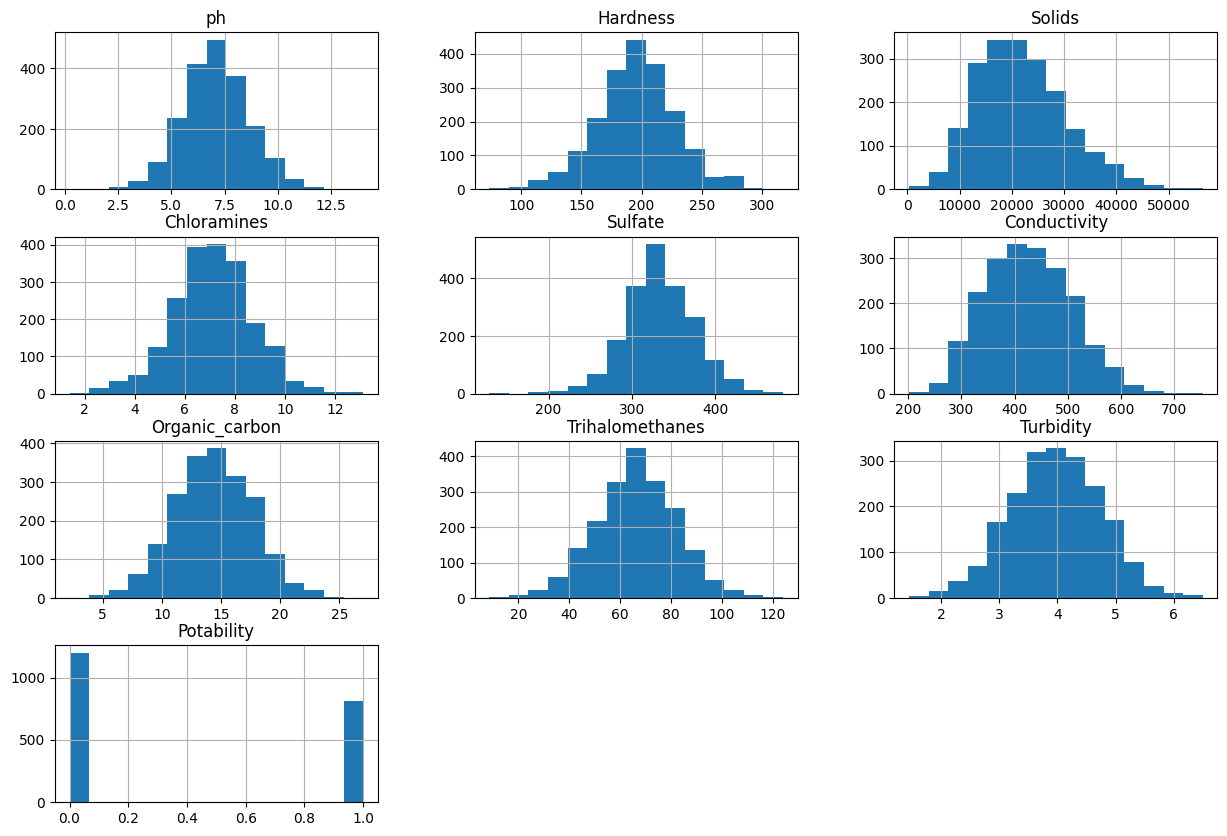

In [ ]:
pandas_df = df_dropped.toPandas()

# Vẽ biểu đồ histogram bằng Pandas
pandas_df.hist(bins=15, figsize=(15, 10), layout=(4, 3))
plt.show()

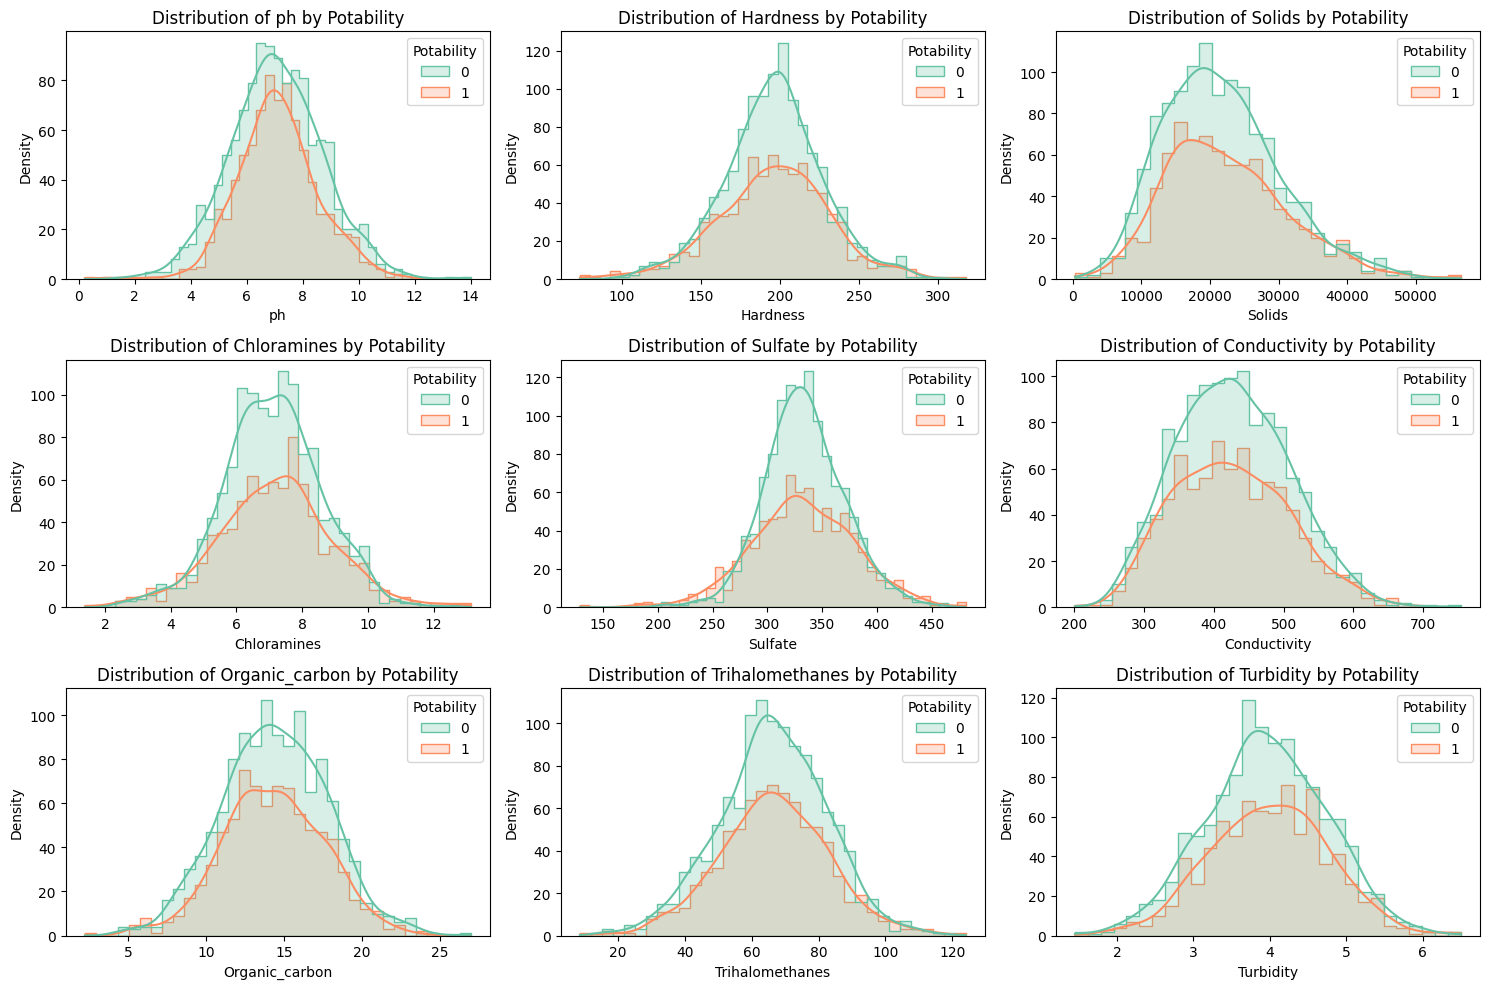

In [ ]:
plt.figure(figsize=(15, 10))

# Define the 'variables' list here
variables = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']

# Convert the Spark DataFrame 'df_dropped' to a Pandas DataFrame
df_dropped_pd = df_dropped.toPandas() # Add this line to define df_dropped_pd

for i, var in enumerate(variables):
    plt.subplot(3, 3, i+1)
    sns.histplot(data=df_dropped_pd, x=var, hue='Potability', kde=True, element="step", palette="Set2")
    plt.title(f'Distribution of {var} by Potability')
    plt.xlabel(var)
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

Trực quan theo độ pH

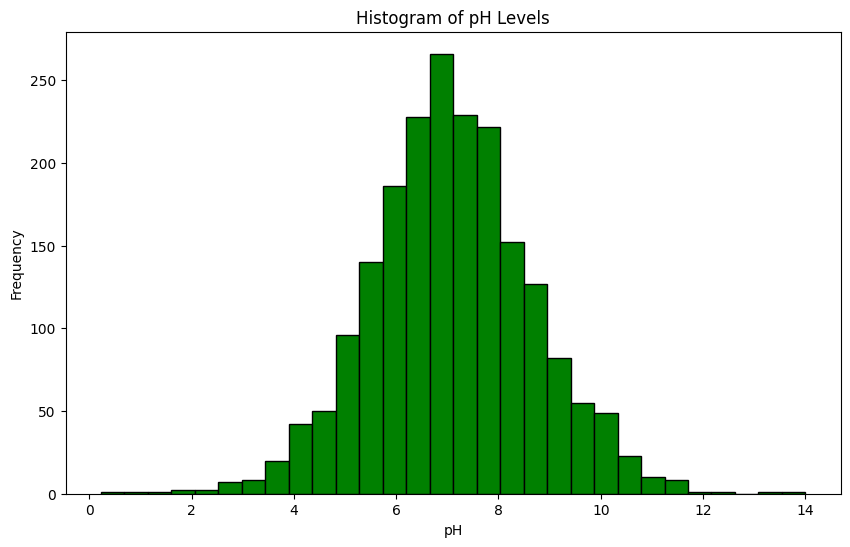

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas for plotting
df_dropped_pd = df_dropped.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_dropped_pd['ph'].dropna(), bins=30, color='green', edgecolor='black')
plt.title('Histogram of pH Levels')
plt.xlabel('pH')
plt.ylabel('Frequency')
plt.show()




*  Đa số các giá trị pH tập trung trong khoảng từ 6 đến 8, với đỉnh cao nhất rơi vào khoảng pH 7.
*  Các giá trị pH thấp hơn (dưới 4) và cao hơn (trên 10) xuất hiện rất ít, biểu thị rằng những trường hợp có độ pH quá thấp hoặc quá cao là hiếm.


*  Phân bố này có dạng gần như đối xứng, cho thấy rằng mức độ pH trong dữ liệu này có xu hướng tập trung xung quanh giá trị trung bình và giảm dần khi di chuyển ra xa khỏi trung tâm.






Trực quan độ pH ảnh hưởng đến độ an toàn của nước

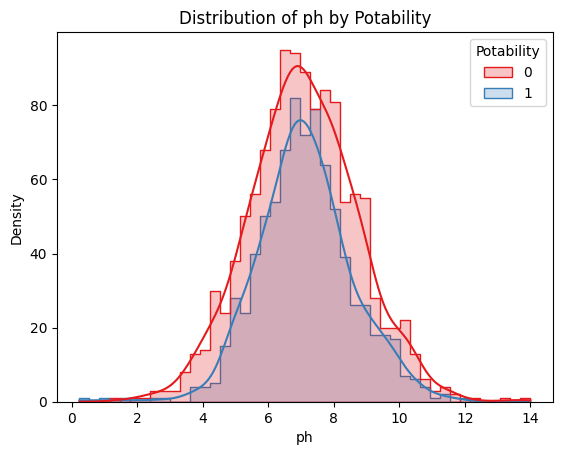

In [ ]:
sns.histplot(data=df_dropped_pd, x='ph', hue='Potability', kde=True, element="step", palette="Set1")
plt.title('Distribution of ph by Potability')
plt.xlabel('ph')
plt.ylabel('Density')
plt.show()


Biểu đồ này so sánh phân phối giá trị pH giữa hai nhóm nước: nước an toàn (Potability = 1) và nước không an toàn (Potability = 0). Dữ liệu cho thấy nước không an toàn thường có pH thấp hơn, trong khi nước an toàn có pH cao hơn.



*   Nước không an toàn (đường màu đỏ) có pH chủ yếu dưới 6, cho thấy nước có thể bị axit hóa, không an toàn để uống.
*   Nước an toàn (đường màu xanh dương) có pH trong khoảng 6-8, là phạm vi pH thường thấy ở nước sạch và an toàn.





Biểu đồ này giúp phân tách nước an toàn và không an toàn theo giá trị pH, nhưng cần lưu ý rằng pH không phải là yếu tố duy nhất quyết định tính an toàn của nước. Các yếu tố khác như độ cứng, nồng độ clo, và các chất hóa học khác cũng cần được xem xét.

Trực quan theo độ Hardness

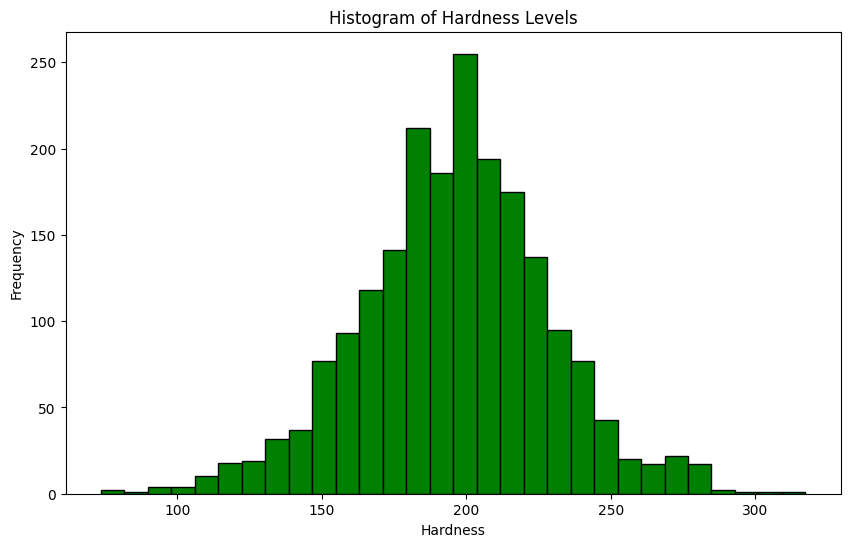

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas for plotting
df_dropped_pd = df_dropped.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_dropped_pd['Hardness'].dropna(), bins=30, color='green', edgecolor='black')
plt.title('Histogram of Hardness Levels')
plt.xlabel('Hardness')
plt.ylabel('Frequency')
plt.show()


Biểu đồ cho thấy độ cứng của nước chủ yếu nằm trong khoảng 150-250, với đỉnh tại khoảng 200. Mẫu nước có độ cứng dưới 100 và trên 250 rất ít, cho thấy nước thường có độ cứng trung bình, và phân bố này gần giống như phân bố chuẩn.

Biểu đồ phân phối độ cứng (Hardness) của nước theo tính an toàn (Potability)

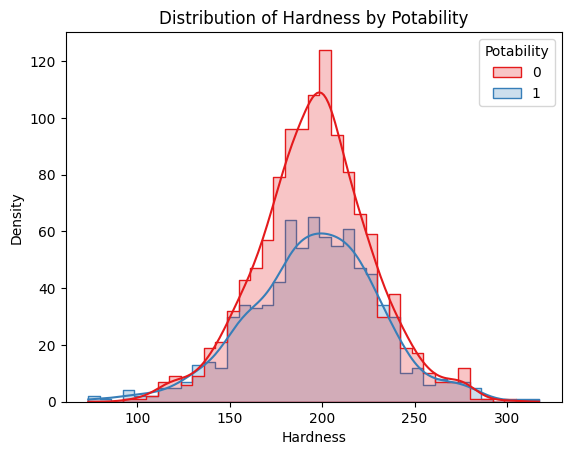

In [ ]:
sns.histplot(data=df_dropped_pd, x='Hardness', hue='Potability', kde=True, element="step", palette="Set1")
plt.title('Distribution of Hardness by Potability')
plt.xlabel('Hardness')
plt.ylabel('Density')
plt.show()


Biểu đồ này cho thấy sự phân bố độ cứng nước (Hardness) theo hai nhóm: nước uống được (Potability = 1, màu xanh) và nước không uống được (Potability = 0, màu đỏ).
*   Nước không an toàn (đường màu đỏ) có phân phối độ cứng rộng và đỉnh cao hơn ở mức độ cứng từ 180 đến 240, cho thấy rằng nước không an toàn có thể chứa nhiều khoáng chất hòa tan hơn.
*   Nước an toàn (đường màu xanh dương) có độ cứng chủ yếu nằm trong khoảng từ 150 đến 220, và phân phối mượt mà hơn, cho thấy nước an toàn thường có độ cứng thấp hơn và ổn định hơn.


--> Nhận xét: Biểu đồ này chỉ ra rằng độ cứng có thể là yếu tố ảnh hưởng đến tính an toàn của nước, nhưng vẫn cần xét thêm các yếu tố khác như pH, nồng độ clo, và các chất hóa học khác để đánh giá đầy đủ tính an toàn của nước.


Trực quan theo Solids

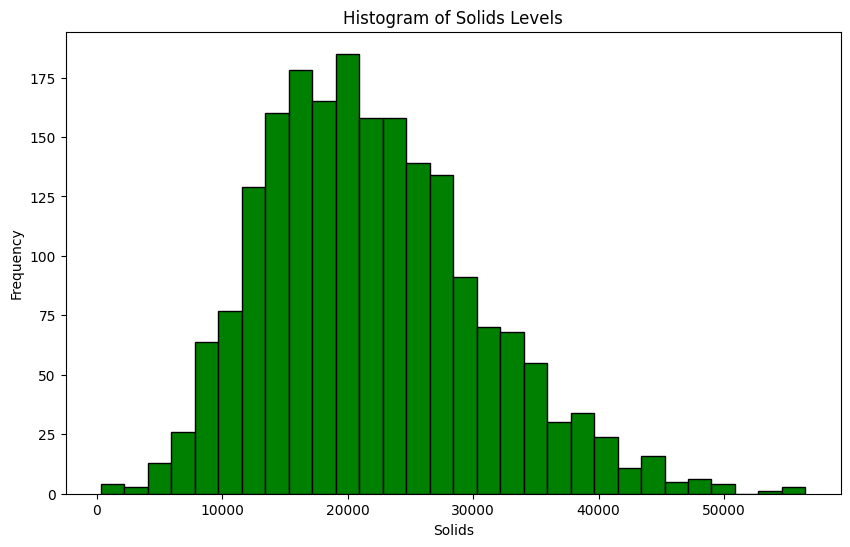

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas for plotting
df_dropped_pd = df_dropped.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_dropped_pd['Solids'].dropna(), bins=30, color='green', edgecolor='black')
plt.title('Histogram of Solids Levels')
plt.xlabel('Solids')
plt.ylabel('Frequency')
plt.show()


Biểu đồ phân phối chất rắn hòa tan (Solids) trong nước theo tính an toàn (Potability)

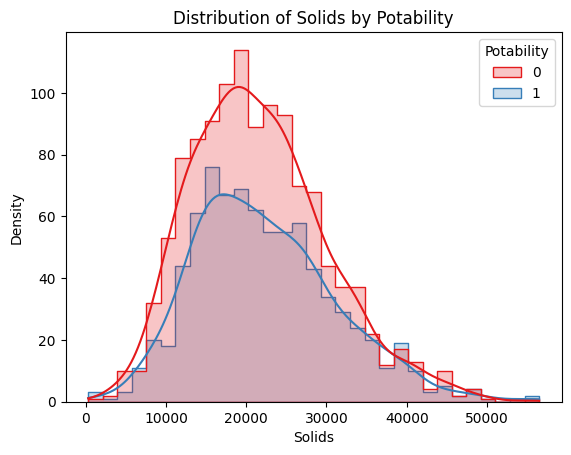

In [ ]:
sns.histplot(data=df_dropped_pd, x='Solids', hue='Potability', kde=True, element="step", palette="Set1")
plt.title('Distribution of Solids by Potability')
plt.xlabel('Solids')
plt.ylabel('Density')
plt.show()


Biểu đồ này so sánh phân phối chất rắn hòa tan (Solids) giữa hai nhóm nước: nước an toàn (Potability = 1) và nước không an toàn (Potability = 0)
*  Nước không an toàn (đường màu đỏ) có phân phối chất rắn hòa tan rộng hơn và đỉnh cao hơn, nằm trong khoảng từ 18,000 đến 22,000.
*   Nước an toàn (đường màu xanh dương) có phân phối hẹp hơn, chủ yếu nằm trong khoảng từ 10,000 đến 20,000.


--> Mặc dù sự phân phối chất rắn hòa tan giữa hai nhóm có sự khác biệt, vẫn có một số sự chồng lấp giữa hai nhóm, đặc biệt ở các mức chất rắn hòa tan thấp (10,000 - 20,000). Điều này cho thấy rằng Solids không phải là yếu tố duy nhất quyết định tính an toàn của nước. Các yếu tố khác như pH, nồng độ các hóa chất có thể ảnh hưởng mạnh mẽ đến chất lượng nước.

Trực quan chất khử trùng Chloramines

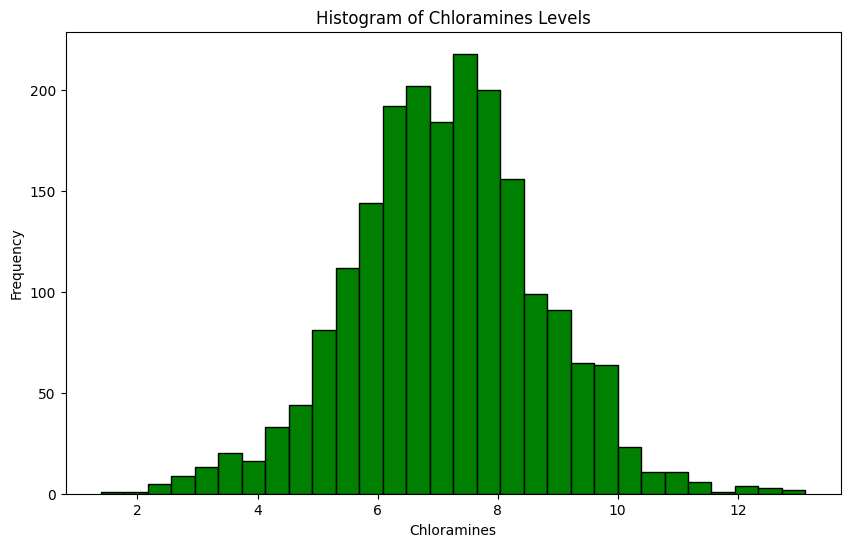

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas for plotting
df_dropped_pd = df_dropped.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_dropped_pd['Chloramines'].dropna(), bins=30, color='green', edgecolor='black')
plt.title('Histogram of Chloramines Levels')
plt.xlabel('Chloramines')
plt.ylabel('Frequency')
plt.show()


Biểu đồ này hiển thị sự phân bố mức độ Chloramines trong mẫu nước.

*   Phân bố: Mức Chloramines chủ yếu nằm trong khoảng từ 4 đến 10 mg/L, với đỉnh cao nhất ở khoảng 7-8 mg/L..
*   Dạng phân bố: Phân bố có dạng gần chuẩn, với số lượng mẫu giảm dần ở hai đầu của dải giá trị.
*   Mẫu cực trị: Ít mẫu có mức Chloramines thấp hơn 2 mg/L hoặc cao hơn 12 mg/L.




Tóm lại, mức Chloramines trong nước thường tập trung quanh mức trung bình, với các giá trị cực đoan là khá hiếm.


Trực quan chất khử trùng Chloramines ảnh hưởng đến độ an toàn của nước

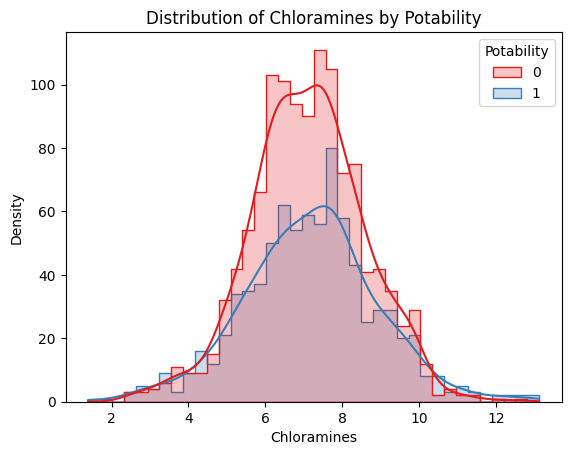

In [ ]:
sns.histplot(data=df_dropped_pd, x='Chloramines', hue='Potability', kde=True, element="step", palette="Set1")
plt.title('Distribution of Chloramines by Potability')
plt.xlabel('Chloramines')
plt.ylabel('Density')
plt.show()


Biểu đồ này cho thấy sự phân bố mức Chloramines giữa hai nhóm nước: uống được (màu xanh) và không uống được (màu đỏ).
*   Nước không an toàn (đường màu đỏ) có phân phối Chloramines rộng hơn, chủ yếu nằm trong khoảng từ 4 đến 8.
*   Nước an toàn (đường màu xanh dương) có phân phối hẹp hơn và chủ yếu nằm trong khoảng từ 5 đến 7, cho thấy rằng nước an toàn có mức Chloramines vừa phải.

--> Tuy nhiên, có sự chồng lấp giữa hai nhóm trong khoảng từ 5 đến 7, điều này cho thấy rằng Chloramines không phải là yếu tố duy nhất quyết định tính an toàn của nước. Các yếu tố khác như pH, độ cứng (Hardness), và chất rắn hòa tan (Solids) cũng cần được xem xét khi đánh giá tính an toàn của nước.

Trực quan theo Sulfate

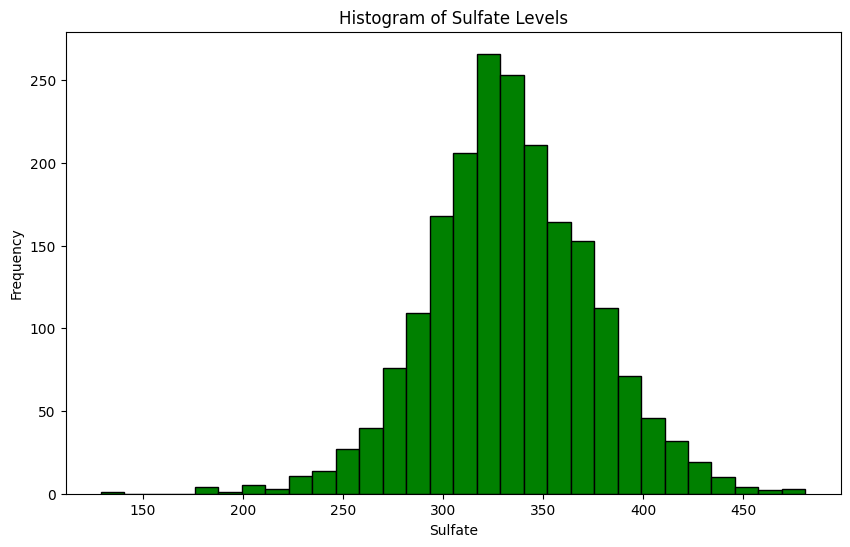

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas for plotting
df_dropped_pd = df_dropped.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_dropped_pd['Sulfate'].dropna(), bins=30, color='green', edgecolor='black')
plt.title('Histogram of Sulfate Levels')
plt.xlabel('Sulfate')
plt.ylabel('Frequency')
plt.show()


Biểu đồ này cho thấy sự phân bố mức Sulfate trong nước.

*   Phân bố: Mức Sulfate chủ yếu nằm trong khoảng 250-400 mg/L, với đỉnh cao nhất quanh 325 mg/L.
*   Dạng phân bố: Phân bố gần chuẩn, với số lượng mẫu giảm dần ở cả hai phía của đỉnh.
*   Mẫu cực trị: Ít mẫu có mức Sulfate dưới 200 mg/L hoặc trên 450 mg/L.

Tóm lại, mức Sulfate trong nước tập trung quanh mức trung bình, với các giá trị cực đoan là khá hiếm.


Trực quan theo Sulfate ảnh hưởng đến độ an toàn của nước

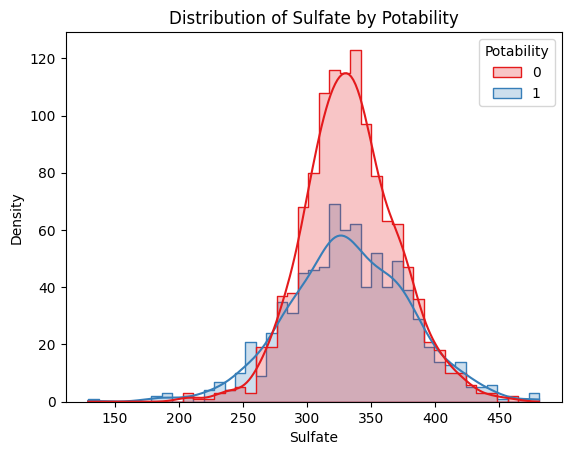

In [ ]:
sns.histplot(data=df_dropped_pd, x='Sulfate', hue='Potability', kde=True, element="step", palette="Set1")
plt.title('Distribution of Sulfate by Potability')
plt.xlabel('Sulfate')
plt.ylabel('Density')
plt.show()


Biểu đồ này thể hiện sự phân bố mức Sulfate giữa hai nhóm nước: uống được (màu xanh) và không uống được (màu đỏ).
*   Nước không an toàn (đường màu đỏ) có phân phối Sulfate rộng hơn, chủ yếu nằm trong khoảng từ 280 đến 340, với đỉnh ở khoảng 300.
*   Nước an toàn (đường màu xanh dương) có phân phối Sulfate hẹp hơn, chủ yếu nằm trong khoảng từ 290 đến 320, cho thấy mức Sulfate vừa phải.


--> Mặc dù có sự phân tách giữa các nhóm, vẫn có sự chồng lấp giữa hai nhóm ở khoảng từ 290 đến 320, điều này cho thấy rằng Sulfate không phải là yếu tố duy nhất quyết định tính an toàn của nước. Các yếu tố khác như pH, Chloramines, và độ cứng (Hardness) cũng cần được xem xét khi đánh giá tính an toàn của nước.

Trực quan theo Conductivity

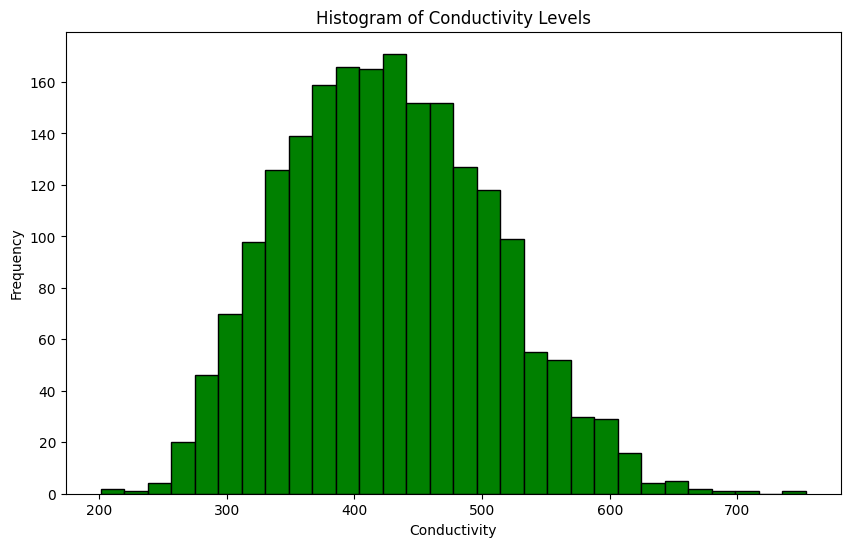

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas for plotting
df_dropped_pd = df_dropped.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_dropped_pd['Conductivity'].dropna(), bins=30, color='green', edgecolor='black')
plt.title('Histogram of Conductivity Levels')
plt.xlabel('Conductivity')
plt.ylabel('Frequency')
plt.show()


Biểu đồ này cho thấy sự phân bố của độ dẫn điện trong nước.


*   Phân bố: Độ dẫn điện tập trung chủ yếu từ 300-600 µS/cm, với đỉnh cao nhất ở khoảng 400-450 µS/cm.

*   Dạng phân bố: Gần với phân bố chuẩn, số mẫu giảm dần khi đi xa khỏi đỉnh.

*   Mẫu cực trị: Rất ít mẫu có độ dẫn điện dưới 200 µS/cm hoặc trên 700 µS/cm.

Tóm lại, độ dẫn điện thường nằm quanh mức trung bình, với các giá trị cực đoan xuất hiện hiếm hoi.


Trực quan theo Conductivity ảnh hưởng đến độ an toàn của nước

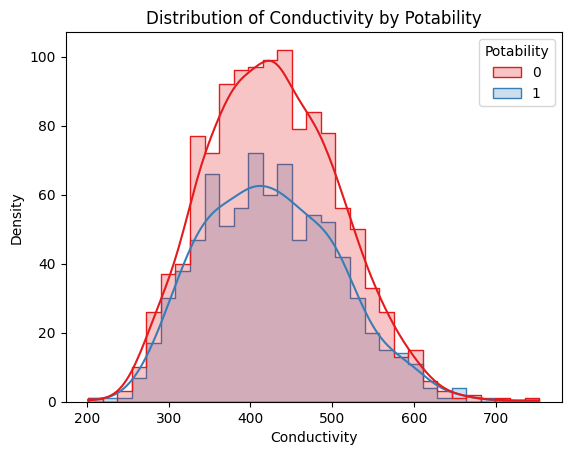

In [ ]:
sns.histplot(data=df_dropped_pd, x='Conductivity', hue='Potability', kde=True, element="step", palette="Set1")
plt.title('Distribution of Conductivity by Potability')
plt.xlabel('Conductivity')
plt.ylabel('Density')
plt.show()


Biểu đồ này thể hiện sự phân bố độ dẫn điện (Conductivity) của nước giữa hai nhóm: nước uống được (màu xanh) và nước không uống được (màu đỏ).
*   Nước không uống được: Tập trung nhiều quanh mức 400-450 µS/cm, với phân bố rộng hơn.
*   Nước uống được: Tập trung chủ yếu từ 350-500 µS/cm, nhưng có mật độ thấp hơn và phân bố hẹp hơn.


--> Nhận xét: Nước không uống được thường có độ dẫn điện cao hơn, đặc biệt trong khoảng 400-450 µS/cm, cho thấy mức độ dẫn điện cao có thể liên quan đến nước không an toàn.

Trực quan theo Organic_carbon

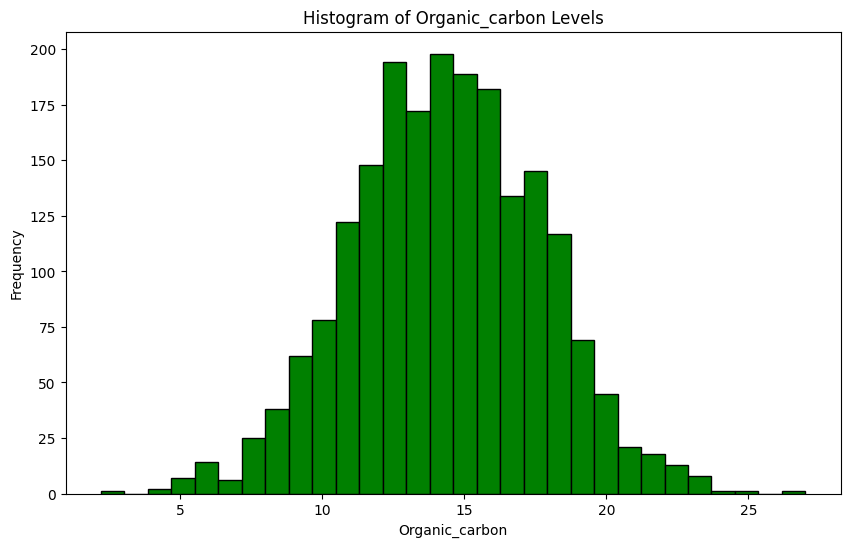

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas for plotting
df_dropped_pd = df_dropped.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_dropped_pd['Organic_carbon'].dropna(), bins=30, color='green', edgecolor='black')
plt.title('Histogram of Organic_carbon Levels')
plt.xlabel('Organic_carbon')
plt.ylabel('Frequency')
plt.show()


Biểu đồ này hiển thị sự phân bố mức độ carbon hữu cơ (Organic Carbon) trong nước.

*   Phân bố: Mức độ carbon hữu cơ chủ yếu nằm trong khoảng 10-20 mg/L, với đỉnh cao nhất ở khoảng 15 mg/L.
*   Dạng phân bố: Phân bố gần chuẩn, với số lượng mẫu giảm dần ở cả hai phía của đỉnh.
*   Mẫu cực trị: Ít mẫu có mức carbon hữu cơ dưới 5 mg/L hoặc trên 25 mg/L.


Tóm lại, mức độ carbon hữu cơ trong nước thường tập trung quanh mức trung bình, với các giá trị cực đoan xuất hiện hiếm hoi.


Trực quan theo Organic_carbon ảnh hưởng đến độ an toàn của nước

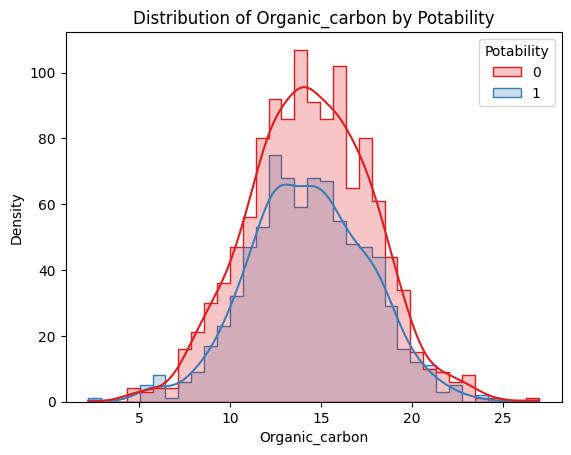

In [ ]:
sns.histplot(data=df_dropped_pd, x='Organic_carbon', hue='Potability', kde=True, element="step", palette="Set1")
plt.title('Distribution of Organic_carbon by Potability')
plt.xlabel('Organic_carbon')
plt.ylabel('Density')
plt.show()


Biểu đồ này cho thấy sự phân bố mức độ carbon hữu cơ (Organic Carbon) giữa hai nhóm nước: uống được (màu xanh) và không uống được (màu đỏ).
*   Nước không uống được: Tập trung chủ yếu quanh mức 15 mg/L, với phân bố rộng hơn.
*   Nước uống được: Cũng tập trung ở khoảng 15 mg/L, nhưng có mật độ thấp hơn và phân bố hẹp hơn.


--> Nhận xét: Nước không uống được thường có mức độ carbon hữu cơ cao hơn, đặc biệt trong khoảng 10-20 mg/L, cho thấy mức carbon hữu cơ cao có thể liên quan đến nước không an toàn.

Trực quan theo Trihalomethanes

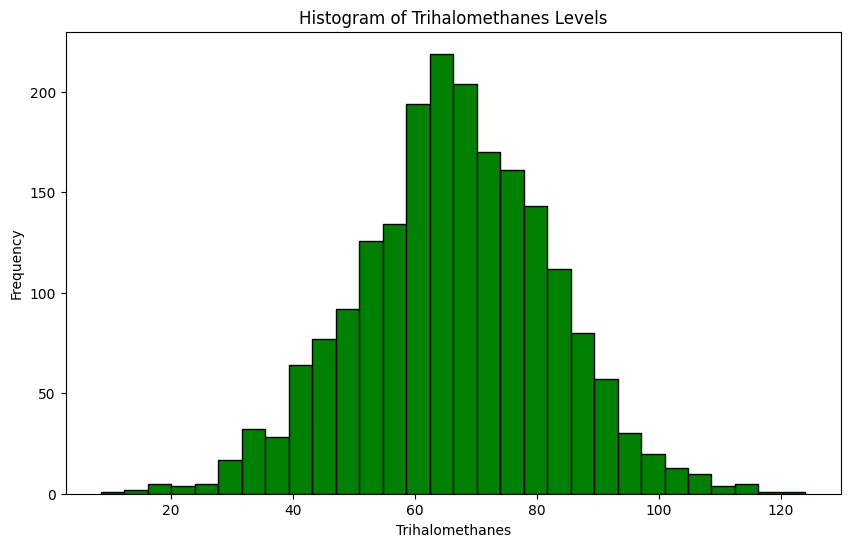

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas for plotting
df_dropped_pd = df_dropped.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_dropped_pd['Trihalomethanes'].dropna(), bins=30, color='green', edgecolor='black')
plt.title('Histogram of Trihalomethanes Levels')
plt.xlabel('Trihalomethanes')
plt.ylabel('Frequency')
plt.show()


Biểu đồ này cho thấy sự phân bố mức độ Trihalomethanes trong nước.


*   Phân bố: Mức Trihalomethanes chủ yếu nằm trong khoảng 40-80 µg/L, với đỉnh cao nhất ở khoảng 60 µg/L.

*   Dạng phân bố: Phân bố gần chuẩn, với số lượng mẫu giảm dần ở cả hai phía của đỉnh.
*   Mẫu cực trị: Rất ít mẫu có mức Trihalomethanes dưới 20 µg/L hoặc trên 100 µg/L.

Tóm lại, mức Trihalomethanes trong nước thường tập trung quanh mức trung bình, với các giá trị cực đoan xuất hiện rất ít.


Trực quan theo Trihalomethanes ảnh hưởng đến độ an toàn của nước

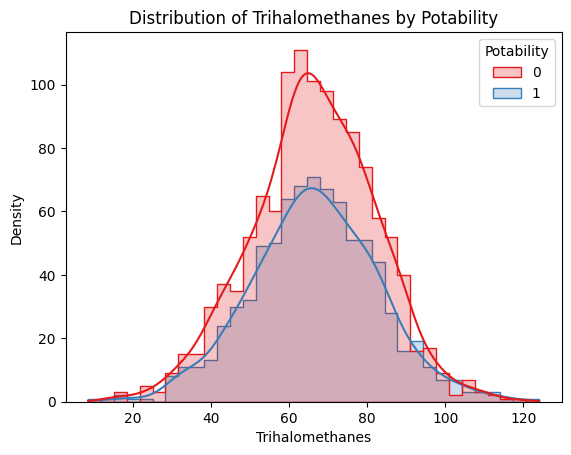

In [ ]:
sns.histplot(data=df_dropped_pd, x='Trihalomethanes', hue='Potability', kde=True, element="step", palette="Set1")
plt.title('Distribution of Trihalomethanes by Potability')
plt.xlabel('Trihalomethanes')
plt.ylabel('Density')
plt.show()


Biểu đồ này cho thấy sự phân bố mức độ Trihalomethanes giữa hai nhóm nước: uống được (màu xanh) và không uống được (màu đỏ).
*   Nước không uống được: Tập trung nhiều nhất quanh mức 60 µg/L, với phân bố rộng hơn.
*   Nước uống được: Tập trung chủ yếu trong khoảng 50-70 µg/L, nhưng mật độ thấp hơn và phân bố hẹp hơn.


--> Nhận xét: Nước không uống được thường có mức Trihalomethanes cao hơn, đặc biệt quanh mức 60 µg/L, cho thấy mức Trihalomethanes cao có thể liên quan đến nước không an toàn.

Trực quan theo Turbidity

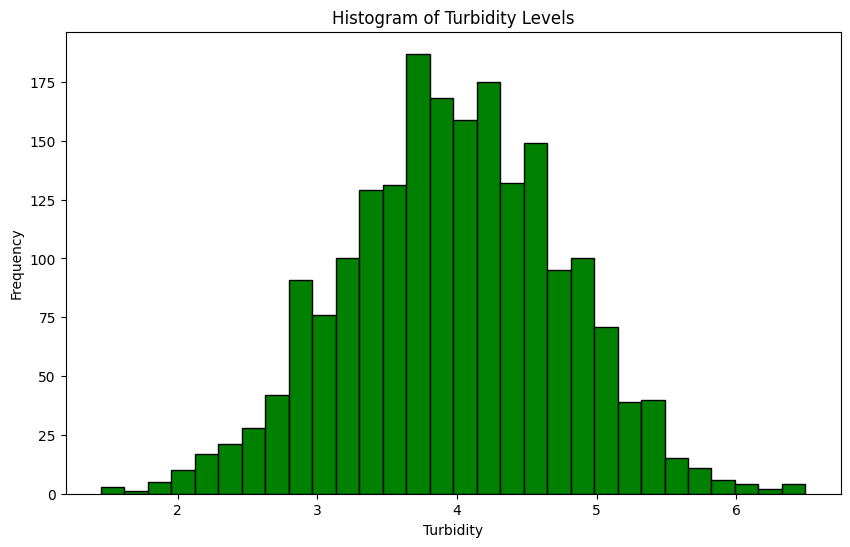

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the PySpark DataFrame to Pandas for plotting
df_dropped_pd = df_dropped.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(df_dropped_pd['Turbidity'].dropna(), bins=30, color='green', edgecolor='black')
plt.title('Histogram of Turbidity Levels')
plt.xlabel('Turbidity')
plt.ylabel('Frequency')
plt.show()


Biểu đồ này hiển thị sự phân bố mức độ đục (Turbidity) trong nước.


*   Phân bố: Mức độ đục chủ yếu nằm trong khoảng 3-5 NTU, với đỉnh cao nhất ở khoảng 4 NTU.

*   Dạng phân bố: Phân bố gần chuẩn, với số lượng mẫu giảm dần ở cả hai phía của đỉnh.
*   Mẫu cực trị: Rất ít mẫu có mức độ đục dưới 2 NTU hoặc trên 6 NTU.

Tóm lại, mức độ đục của nước thường tập trung quanh mức trung bình, với các giá trị cực đoan là khá hiếm.


Trực quan theo Turbidity ảnh hưởng đến độ an toàn của nước

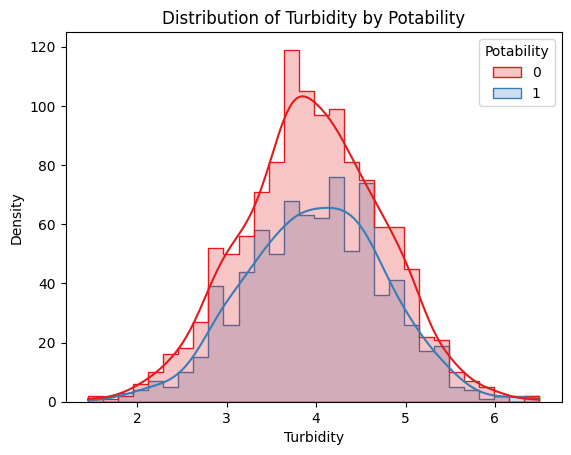

In [ ]:
sns.histplot(data=df_dropped_pd, x='Turbidity', hue='Potability', kde=True, element="step", palette="Set1")
plt.title('Distribution of Turbidity by Potability')
plt.xlabel('Turbidity')
plt.ylabel('Density')
plt.show()


Biểu đồ này cho thấy sự phân bố mức độ đục (Turbidity) giữa hai nhóm nước: uống được (màu xanh) và không uống được (màu đỏ).
*   Nước không uống được: Mật độ cao nhất tập trung quanh mức 4 NTU, với phân bố rộng hơn.
*   Nước uống được: Cũng tập trung quanh mức 4 NTU, nhưng có mật độ thấp hơn và phân bố hẹp hơn.


--> Nhận xét: Nước không uống được thường có mức độ đục cao hơn, đặc biệt quanh mức 4 NTU, cho thấy mức độ đục cao có thể liên quan đến nước không an toàn.

# Huấn luyện mô hình

Logistic Regression

In [ ]:
# Khởi tạo mô hình Logistic Regression
lr = LogisticRegression(labelCol="Potability", featuresCol="features")

# Huấn luyện mô hình trên tập dữ liệu huấn luyện
lr_model = lr.fit(train)


In [ ]:
# Thực hiện dự đoán trên tập dữ liệu kiểm tra
lr_predictions = lr_model.transform(test)

# Hiển thị một số kết quả dự đoán
lr_predictions.select("Potability", "prediction", "probability").show(10)


+----------+----------+--------------------+
|Potability|prediction|         probability|
+----------+----------+--------------------+
|         0|       0.0|[0.61604256157384...|
|         0|       0.0|[0.60879477945195...|
|         0|       0.0|[0.61821207667206...|
|         0|       0.0|[0.55681548586321...|
|         1|       0.0|[0.68176174059191...|
|         0|       0.0|[0.57630127314571...|
|         0|       0.0|[0.60787573529029...|
|         0|       0.0|[0.59358759972538...|
|         0|       0.0|[0.58983567013995...|
|         0|       0.0|[0.62271572042265...|
+----------+----------+--------------------+
only showing top 10 rows



In [ ]:
# Đánh giá độ chính xác của mô hình
evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(lr_predictions)
print(f"Accuracy of the model: {accuracy}")


Accuracy of the model: 0.5967741935483871


Random Forest

In [ ]:
# Khởi tạo mô hình Random Forest
rf = RandomForestClassifier(labelCol="Potability", featuresCol="features", numTrees=100)

# Huấn luyện mô hình trên tập dữ liệu huấn luyện
rf_model = rf.fit(train)


In [ ]:
# Thực hiện dự đoán trên tập kiểm tra
rf_predictions = rf_model.transform(test)

# Hiển thị một số kết quả dự đoán
rf_predictions.select("Potability", "prediction", "probability").show(10)


+----------+----------+--------------------+
|Potability|prediction|         probability|
+----------+----------+--------------------+
|         0|       0.0|[0.68234634612721...|
|         0|       0.0|[0.70229470065991...|
|         0|       0.0|[0.72053362461659...|
|         0|       0.0|[0.53844905931008...|
|         1|       1.0|[0.42511093877195...|
|         0|       0.0|[0.72697814323972...|
|         0|       0.0|[0.71414436387984...|
|         0|       0.0|[0.71903444484482...|
|         0|       0.0|[0.76438092819788...|
|         0|       0.0|[0.70421157086985...|
+----------+----------+--------------------+
only showing top 10 rows



In [ ]:
# Đánh giá độ chính xác của mô hình
rf_evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="accuracy")
rf_accuracy = rf_evaluator.evaluate(rf_predictions)
print(f"Accuracy of the Random Forest model: {rf_accuracy}")


Accuracy of the Random Forest model: 0.6684587813620072


Decision Tree Classifier

In [ ]:
# Khởi tạo mô hình Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="Potability", featuresCol="features")

# Huấn luyện mô hình trên tập dữ liệu huấn luyện
dt_model = dt.fit(train)


In [ ]:
# Thực hiện dự đoán trên tập kiểm tra
dt_predictions = dt_model.transform(test)

# Hiển thị một số kết quả dự đoán
dt_predictions.select("Potability", "prediction", "probability").show(10)


+----------+----------+--------------------+
|Potability|prediction|         probability|
+----------+----------+--------------------+
|         0|       0.0|[0.62162162162162...|
|         0|       0.0|[0.82242990654205...|
|         0|       0.0|[0.82242990654205...|
|         0|       1.0|           [0.0,1.0]|
|         1|       1.0|[0.06976744186046...|
|         0|       0.0|[0.82242990654205...|
|         0|       0.0|[0.82242990654205...|
|         0|       0.0|[0.82242990654205...|
|         0|       0.0|[0.82242990654205...|
|         0|       0.0|[0.67391304347826...|
+----------+----------+--------------------+
only showing top 10 rows



In [ ]:
# Đánh giá độ chính xác của mô hình
dt_evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="accuracy")
dt_accuracy = dt_evaluator.evaluate(dt_predictions)
print(f"Accuracy of the Decision Tree model: {dt_accuracy}")


Accuracy of the Decision Tree model: 0.6541218637992832


# So sánh độ chính xác của các phương pháp dự đoán

In [ ]:
# Khởi tạo bộ đánh giá
evaluator = MulticlassClassificationEvaluator(labelCol="Potability", predictionCol="prediction", metricName="accuracy")

# Tính toán độ chính xác
accuracy_dict = {}
# Pass the logistic regression predictions DataFrame (assuming you have it as 'lr_predictions')
accuracy_dict["Logistic Regression"] = evaluator.evaluate(lr_predictions)
accuracy_dict["Random Forest"] = evaluator.evaluate(rf_predictions)
accuracy_dict["Decision Tree"] = evaluator.evaluate(dt_predictions)


for model, accuracy in accuracy_dict.items():
    print(f"Accuracy of {model}: {accuracy}")

Accuracy of Logistic Regression: 0.5967741935483871
Accuracy of Random Forest: 0.6684587813620072
Accuracy of Decision Tree: 0.6541218637992832


/tmp/ipython-input-2546840918.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette="deep")


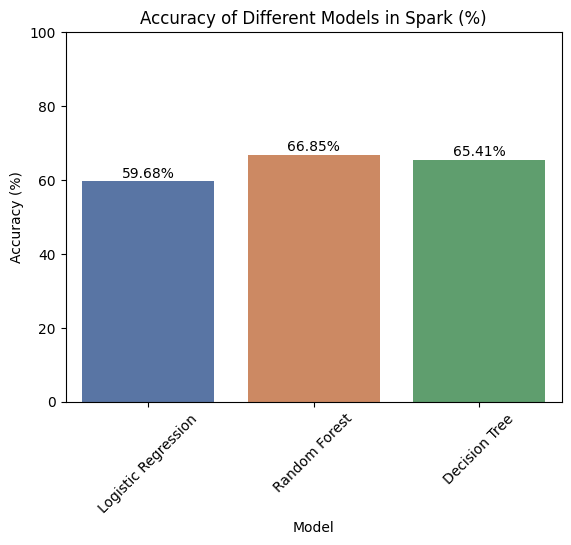

In [ ]:
# Import necessary libraries
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Convert accuracy values to percentage
accuracy_dict = {k: v * 100 for k, v in accuracy_dict.items()}

# Create a DataFrame from the accuracy dictionary
accuracy_df = pd.DataFrame(list(accuracy_dict.items()), columns=['Model', 'Accuracy'])

# Plot the accuracy comparison
sns.barplot(x='Model', y='Accuracy', data=accuracy_df, palette="deep")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.ylim(0, 100)  # Set y-axis limits between 0 and 100

# Display accuracy values on top of each bar
for index, row in accuracy_df.iterrows():
    plt.text(index, row['Accuracy'] + 1, f"{row['Accuracy']:.2f}%", color='black', ha="center")

plt.title("Accuracy of Different Models in Spark (%)")
plt.ylabel("Accuracy (%)")
plt.show()


Từ 3 phương pháp dự đoán bao gồm: Logistic Regression, Decision Tree Classifier, Random Forest. Ta có thể thấy được rằng mô hình Random Forest là mô hình dự đoán tốt nhất.